In [16]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
import matplotlib.pyplot as plt

In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist

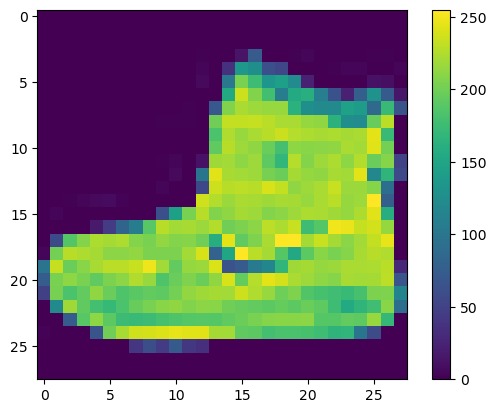

In [4]:
plt.figure()
plt.imshow(X_train_full[0])
plt.colorbar()

In [5]:
X_train_full = X_train_full.astype("float32") / 255
X_test = X_test.astype("float32") / 255

In [6]:
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

In [7]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [7]:
def build_model(hp):
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    kernel_list = hp.Choice("kernel_initializer", values=["random_normal", "random_uniform", "zeros", "ones", "glorot_normal", "glorot_uniform"])
    optimizer = hp.Choice("optimizer", values=["sgd", "adam", "adadelta", "rmsprop", "adamax", "adagrad"])
    activation_list = hp.Choice("activation", values=['relu', 'softmax', 'tanh', 'elu', 'sigmoid'])
    drop_out = hp.Float("drop_out", min_value=.2, max_value=1)
    
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "adadelta":
        optimizer = tf.keras.optimizers.Adadelta(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "adamax":
        optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)
        
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten())
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation=activation_list, kernel_initializer=kernel_list))
        model.add(tf.keras.layers.Dropout(drop_out))
    model.add(tf.keras.layers.Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model

In [8]:
random_search_tuner = kt.RandomSearch(
    build_model, 
    objective="val_accuracy", 
    max_trials=20,
    executions_per_trial=5,
    overwrite=True,
    directory="my_fashion_mnist", 
    project_name="HP_Fashion_MNIST", 
    seed=42)

random_search_tuner.search(X_train, y_train, epochs=10,
                           validation_data=(X_valid, y_valid))

Trial 20 Complete [00h 02m 26s]
val_accuracy: 0.11763999760150909

Best val_accuracy So Far: 0.842960000038147
Total elapsed time: 03h 56m 51s
INFO:tensorflow:Oracle triggered exit


In [9]:
top3_models = random_search_tuner.get_best_models(num_models=5)
best_model = top3_models[0]

In [10]:
top3_params = random_search_tuner.get_best_hyperparameters(num_trials=5)
for i in range(len(top3_params)):
    print(f'Top Param {i} : \n {top3_params[i].values}\n')  # best hyperparameter values

Top Param 0 : 
 {'n_hidden': 6, 'n_neurons': 140, 'learning_rate': 0.001462772808938758, 'kernel_initializer': 'random_uniform', 'optimizer': 'rmsprop', 'activation': 'elu', 'drop_out': 0.3066681333770488}

Top Param 1 : 
 {'n_hidden': 1, 'n_neurons': 117, 'learning_rate': 0.006678619769811224, 'kernel_initializer': 'glorot_normal', 'optimizer': 'adamax', 'activation': 'tanh', 'drop_out': 0.35562979834654485}

Top Param 2 : 
 {'n_hidden': 2, 'n_neurons': 155, 'learning_rate': 0.0009452767099282696, 'kernel_initializer': 'glorot_normal', 'optimizer': 'adagrad', 'activation': 'elu', 'drop_out': 0.2980296105401524}

Top Param 3 : 
 {'n_hidden': 6, 'n_neurons': 64, 'learning_rate': 0.0038287047044982298, 'kernel_initializer': 'random_uniform', 'optimizer': 'rmsprop', 'activation': 'relu', 'drop_out': 0.36293635793684126}

Top Param 4 : 
 {'n_hidden': 1, 'n_neurons': 135, 'learning_rate': 0.0003069273045576997, 'kernel_initializer': 'zeros', 'optimizer': 'adamax', 'activation': 'softmax', '

In [11]:
best_trial= random_search_tuner.oracle.get_best_trials(num_trials=5)
for i in range(len(best_trial)):
    print(f'Best Train {i}')
    best_trial[i].summary()
    print(f'--------------')

Best Train 0
Trial summary
Hyperparameters:
n_hidden: 6
n_neurons: 140
learning_rate: 0.001462772808938758
kernel_initializer: random_uniform
optimizer: rmsprop
activation: elu
drop_out: 0.3066681333770488
Score: 0.842960000038147
--------------
Best Train 1
Trial summary
Hyperparameters:
n_hidden: 1
n_neurons: 117
learning_rate: 0.006678619769811224
kernel_initializer: glorot_normal
optimizer: adamax
activation: tanh
drop_out: 0.35562979834654485
Score: 0.754040002822876
--------------
Best Train 2
Trial summary
Hyperparameters:
n_hidden: 2
n_neurons: 155
learning_rate: 0.0009452767099282696
kernel_initializer: glorot_normal
optimizer: adagrad
activation: elu
drop_out: 0.2980296105401524
Score: 0.6581200003623963
--------------
Best Train 3
Trial summary
Hyperparameters:
n_hidden: 6
n_neurons: 64
learning_rate: 0.0038287047044982298
kernel_initializer: random_uniform
optimizer: rmsprop
activation: relu
drop_out: 0.36293635793684126
Score: 0.6359600067138672
--------------
Best Train 4

In [16]:
best_trial[0].metrics.get_last_value("val_accuracy")

0.842960000038147

In [ ]:
best_model.fit(X_train_full, y_train_full, epochs=10)
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)

**CIFAR10 fitting on top 3 model of Hyperparameter Tuning of Fashion MNIST MLP**

In [25]:
CIFAR_10 = tf.keras.datasets.cifar10.load_data()
(x_train, y_train), (x_test, y_test) = CIFAR_10

In [26]:
batch_size = 128
num_classes = 10
epochs = 20

In [27]:
def data_reshape(dataset, *size):
    return dataset.reshape(size)

In [28]:
x_train = data_reshape(x_train, x_train.shape[0],3072)
x_test = data_reshape(x_test, x_test.shape[0], 3072)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

50000 train samples
10000 test samples


In [29]:
x_train = data_reshape(x_train, x_train.shape[0],3072)
x_test = data_reshape(x_test, x_test.shape[0], 3072)
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")

50000 train samples
10000 test samples


In [32]:
# Best Train 1
n_hidden = 6
n_neurons = 140
learning_rate = 0.001462772808938758
kernel_initializer ='random_uniform'
optimizer = 'rmsprop'
activation = 'elu'
drop_out = 0.3066681333770488
# Score: 0.842960000038147

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.Dropout(drop_out))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

model.fit(x_train, y_train, epochs=epochs, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss : {test_loss} \n Test Accuracy : {test_accuracy:.3%}')

Epoch 1/20
1250/1250 [==============================] - 22s 16ms/step - loss: 2.3041 - accuracy: 0.1032 - val_loss: 2.3047 - val_accuracy: 0.0952
Epoch 2/20
1250/1250 [==============================] - 19s 15ms/step - loss: 2.2262 - accuracy: 0.1317 - val_loss: 2.0696 - val_accuracy: 0.1989
Epoch 3/20
1250/1250 [==============================] - 16s 13ms/step - loss: 2.0892 - accuracy: 0.1810 - val_loss: 2.0589 - val_accuracy: 0.2002
Epoch 4/20
1250/1250 [==============================] - 12s 9ms/step - loss: 2.0281 - accuracy: 0.2190 - val_loss: 1.9866 - val_accuracy: 0.2454
Epoch 5/20
1250/1250 [==============================] - 12s 9ms/step - loss: 1.9801 - accuracy: 0.2416 - val_loss: 1.9367 - val_accuracy: 0.2647
Epoch 6/20
1250/1250 [==============================] - 10s 8ms/step - loss: 1.9650 - accuracy: 0.2490 - val_loss: 1.9420 - val_accuracy: 0.2588
Epoch 7/20
1250/1250 [==============================] - 12s 10ms/step - loss: 1.9599 - accuracy: 0.2498 - val_loss: 1.9303 - va

In [33]:
# Best Train 1
n_hidden = 1
n_neurons = 117
learning_rate = 0.006678619769811224
kernel_initializer = 'glorot_normal'
optimizer = 'adamax'
activation = 'tanh'
drop_out = 0.35562979834654485
# Score = 0.754040002822876

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.Dropout(drop_out))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

model.fit(x_train, y_train, epochs=epochs, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss : {test_loss} \n Test Accuracy : {test_accuracy:.3%}')

Epoch 1/20
1250/1250 [==============================] - 17s 13ms/step - loss: 2.1479 - accuracy: 0.2395 - val_loss: 2.0317 - val_accuracy: 0.2933
Epoch 2/20
1250/1250 [==============================] - 14s 12ms/step - loss: 1.9833 - accuracy: 0.2988 - val_loss: 1.9474 - val_accuracy: 0.3172
Epoch 3/20
1250/1250 [==============================] - 15s 12ms/step - loss: 1.9272 - accuracy: 0.3212 - val_loss: 1.9109 - val_accuracy: 0.3218
Epoch 4/20
1250/1250 [==============================] - 15s 12ms/step - loss: 1.8962 - accuracy: 0.3347 - val_loss: 1.8870 - val_accuracy: 0.3449
Epoch 5/20
1250/1250 [==============================] - 15s 12ms/step - loss: 1.8740 - accuracy: 0.3436 - val_loss: 1.8683 - val_accuracy: 0.3453
Epoch 6/20
1250/1250 [==============================] - 16s 13ms/step - loss: 1.8560 - accuracy: 0.3501 - val_loss: 1.8548 - val_accuracy: 0.3620
Epoch 7/20
1250/1250 [==============================] - 16s 13ms/step - loss: 1.8406 - accuracy: 0.3574 - val_loss: 1.8385 -

In [37]:
# Best Train 2
n_hidden = 2
n_neurons = 155
learning_rate = 0.0009452767099282696
kernel_initializer = 'glorot_normal'
optimizer = 'adagrad'
activation = 'elu'
drop_out = 0.2980296105401524
# Score = 0.6581200003623963 #16.3

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten())
for _ in range(n_hidden):
    model.add(tf.keras.layers.Dense(n_neurons, activation=activation, kernel_initializer=kernel_initializer))
    model.add(tf.keras.layers.Dropout(drop_out))
model.add(tf.keras.layers.Dense(10, activation="softmax"))
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])

model.fit(x_train, y_train, epochs=epochs, validation_split=0.2)
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test Loss : {test_loss} \n Test Accuracy : {test_accuracy:.3%}')

Epoch 1/20
1250/1250 [==============================] - 12s 9ms/step - loss: 2.3024 - accuracy: 0.1028 - val_loss: 2.3023 - val_accuracy: 0.1124
Epoch 2/20
1250/1250 [==============================] - 20s 16ms/step - loss: 2.3022 - accuracy: 0.1111 - val_loss: 2.3021 - val_accuracy: 0.1003
Epoch 3/20
1250/1250 [==============================] - 22s 17ms/step - loss: 2.3020 - accuracy: 0.1102 - val_loss: 2.3020 - val_accuracy: 0.1122
Epoch 4/20
1250/1250 [==============================] - 23s 18ms/step - loss: 2.3018 - accuracy: 0.1176 - val_loss: 2.3018 - val_accuracy: 0.1046
Epoch 5/20
1250/1250 [==============================] - 22s 17ms/step - loss: 2.3017 - accuracy: 0.1140 - val_loss: 2.3016 - val_accuracy: 0.1061
Epoch 6/20
1250/1250 [==============================] - 23s 18ms/step - loss: 2.3015 - accuracy: 0.1213 - val_loss: 2.3015 - val_accuracy: 0.1069
Epoch 7/20
1250/1250 [==============================] - 22s 18ms/step - loss: 2.3013 - accuracy: 0.1198 - val_loss: 2.3013 - 

In [40]:
print(f'Test Loss : {test_loss} \nTest Accuracy : {test_accuracy:.3%}')

Test Loss : 2.298417806625366 
Test Accuracy : 16.660%
